# Hidden Markov Model with Poisson emissions and Time-Varying Transitions

## Summary

The following exposition uses [`pymc3-hmm`](https://github.com/AmpersandTV/pymc3-hmm) to simulate and estimate a hidden Markov model (HMM) with a time-varying transition matrix and emissions consisting of Poisson random variables.

In [12]:
import numpy as np
import pandas as pd

import patsy

import theano.tensor as tt

import pymc3 as pm

from pymc3_hmm.utils import multilogit_inv
from pymc3_hmm.distributions import SwitchingProcess, DiscreteMarkovChain
from pymc3_hmm.step_methods import FFBSStep

## Introduction

Our observation model can be described as follows:

\begin{align}
  \label{eq:pois-zero-model}
  \left( Y_t \mid S_t = s \right) &\sim \operatorname{Pois}\left( \mu_s \right),\quad
  \\
  S_t &\sim \operatorname{Bern}\left( \pi_t \right)
  \;,
\end{align}
where $y_t \sim Y_t$ are the observed values sampled from the observation distribution, $Y_t$, spanning $t \in \left\{0, \dots, T \right\}$.

The "hidden" state sequence, $\{S_t\}$, is driven by the following Markov relationship:

\begin{equation*}
    \operatorname{P}\left(S_t \mid S_{t-1}\right) \triangleq \Gamma_{t,t-1} \in \mathbb{R}^{2 \times 2}_{[0, 1]}
\end{equation*}

The marginal state probability, $\pi_t$, is then given by

\begin{equation*}
  \begin{aligned}
    \operatorname{P}\left( S_t \right)
    &= \int_{S_{t-1}} \operatorname{P}\left(S_t \mid S_{t-1}\right)
    \operatorname{dP}\left(S_{t-1}\right)
    \\
    &=
    \begin{pmatrix}
      \Gamma^{(0, 0)}_{t,t-1} & \Gamma^{(0, 1)}_{t,t-1}
      \\
      \Gamma^{(1, 0)}_{t,t-1} & \Gamma^{(1, 1)}_{t,t-1}
    \end{pmatrix}^\top
    \begin{pmatrix}
      \pi_{t-1}
      \\
      1 - \pi_{t-1}
    \end{pmatrix}
    \\
    &=
      \begin{pmatrix}
      \pi_{t}
      \\
      1 - \pi_{t}
    \end{pmatrix}
  \;.
  \end{aligned}
\end{equation*}

In this example, the rows of our transition matrix, $\Gamma^{(r)}_{t, t-1}$ for $r \in \{0, 1\}$, are driven by a logistic regression:

\begin{gather*}
  \Gamma^{(r)}_{t, t-1} = \operatorname{logit^{-1}}\left( X_t \xi_r \right)
\end{gather*}

where $X_t \in \mathbb{R}^{T \times N}$ is a covariate matrix and $\xi_r \in \mathbb{R}^N$ is the regression parameter vector for row $r$.

In the remainder of this exposition, we will assume normal priors for each $\xi_r$, the conjugate Gamma prior for $\mu$, and a Dirichlet prior for $\pi_0$.

## Simulation

For these simulations, we will generate a time series and make the $\xi_r$ regression consist of fixed-effects for a seasonal component based on weekdays.  In other words, the transition probabilities will vary based on the day of week.

In [13]:
def create_poisson_zero_hmm_tv(mu_1, mu_2, xis, pi_0, observed):

    z_tt = tt.tensordot(X_df.values, xis, axes=((1,), (0,)))

    P_tt = multilogit_inv(z_tt)

    P_rv = pm.Deterministic("P_t", P_tt)

    S_rv = DiscreteMarkovChain("S_t", P_rv, pi_0, shape=np.shape(observed)[-1])

    # S_rv.tag.test_value = np.array(observed > 0, dtype=np.int32)

    Y_rv = SwitchingProcess(
        "Y_t",
        [pm.Poisson.dist(mu_1), pm.Poisson.dist(mu_1 + mu_2)],
        S_rv,
        observed=observed,
    )
    return Y_rv



In [14]:
np.random.seed(2032)

start_date = pd.Timestamp("2020-01-01 00:00:00")
time_index = pd.date_range(
    start=start_date, end=start_date + pd.Timedelta("30W"), closed="left", freq="1h"
)
X_ind_df = pd.DataFrame(
    {
        "weekday": time_index.weekday,
    },
    index=time_index,
)

formula_str = "~ 1 + C(weekday)"
X_df = patsy.dmatrix(formula_str, X_ind_df, return_type="dataframe")

xi_0_true = pd.Series(
    # The coefficients used to compute the state zero-to-zero transition probabilities
    np.array([2.0, -5.0, -3.0, 0.0, 0.0, -5.0, -5.0]),
    index=X_df.columns,
)

xi_1_true = pd.Series(
    # The coefficients for the state one-to-zero transition probabilities
    np.array([-2.0, -1.0, 3.0, 0.0, 0.0, 5.0, 5.0]),
    index=X_df.columns,
)

xis_true = tt.as_tensor(np.stack([xi_0_true, xi_1_true], axis=1)[..., None], name="xis")

mu_1_true = 50
mu_2_true = 20
p_0_true = tt.as_tensor(np.r_[0.0, 1.0])

with pm.Model(theano_config={"compute_test_value": "ignore"}) as sim_model:
    _ = create_poisson_zero_hmm_tv(
        mu_1_true, mu_2_true, xis_true, p_0_true, np.zeros(X_df.shape[0])
    )

sim_point = pm.sample_prior_predictive(samples=1, model=sim_model)
sim_point["Y_t"] = sim_point["Y_t"].squeeze()

y_t = sim_point["Y_t"]

## Estimation

We will use the "true" data-generating observation model to estimate the parameters $\mu$ and $\Gamma_{t, t-1}$ (the latter as rows denoted by `p_0` and `p_1`).  For demonstration purposes, we choose hyper-parameters for the $\mu_s$ priors that are somewhat far from the true $\mu_s$ values.

The sampling steps for $S_t$ are performed using forward-filtering backward-sampling (FFBS), while sampling for $\mu_s$, $\pi_0$, and the $\xi_r$ use NUTS.


In [15]:
import theano


theano.config.allow_gc = False

with pm.Model(theano_config={"compute_test_value": "ignore"}) as test_model:
    E_mu, Var_mu = 10.0, 10000.0
    mu_1_rv = pm.Gamma("mu_1", E_mu ** 2 / Var_mu, E_mu / Var_mu)
    mu_2_rv = pm.Gamma("mu_2", E_mu ** 2 / Var_mu, E_mu / Var_mu)

    p_0_rv = pm.Dirichlet("p_0", np.r_[1, 1])

    xis_rv = pm.Normal("xis", 0, 10, shape=(X_df.shape[1], 2, 1))

    _ = create_poisson_zero_hmm_tv(mu_1_rv, mu_2_rv, xis_rv, p_0_rv, y_t)

with test_model:
    states_step = FFBSStep([test_model.S_t])
    mu_step = pm.NUTS(
        [test_model.mu_1, test_model.mu_2, test_model.xis, test_model.p_0]
    )

    posterior_trace = pm.sample(
        step=[states_step, mu_step],
        return_inferencedata=True,
        chains=1,
        progressbar=True,
    )


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{eq,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{eq,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{switch,no_inplace}.0
WARNING 

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 645 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{eq,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{eq,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Can

## Posterior Samples

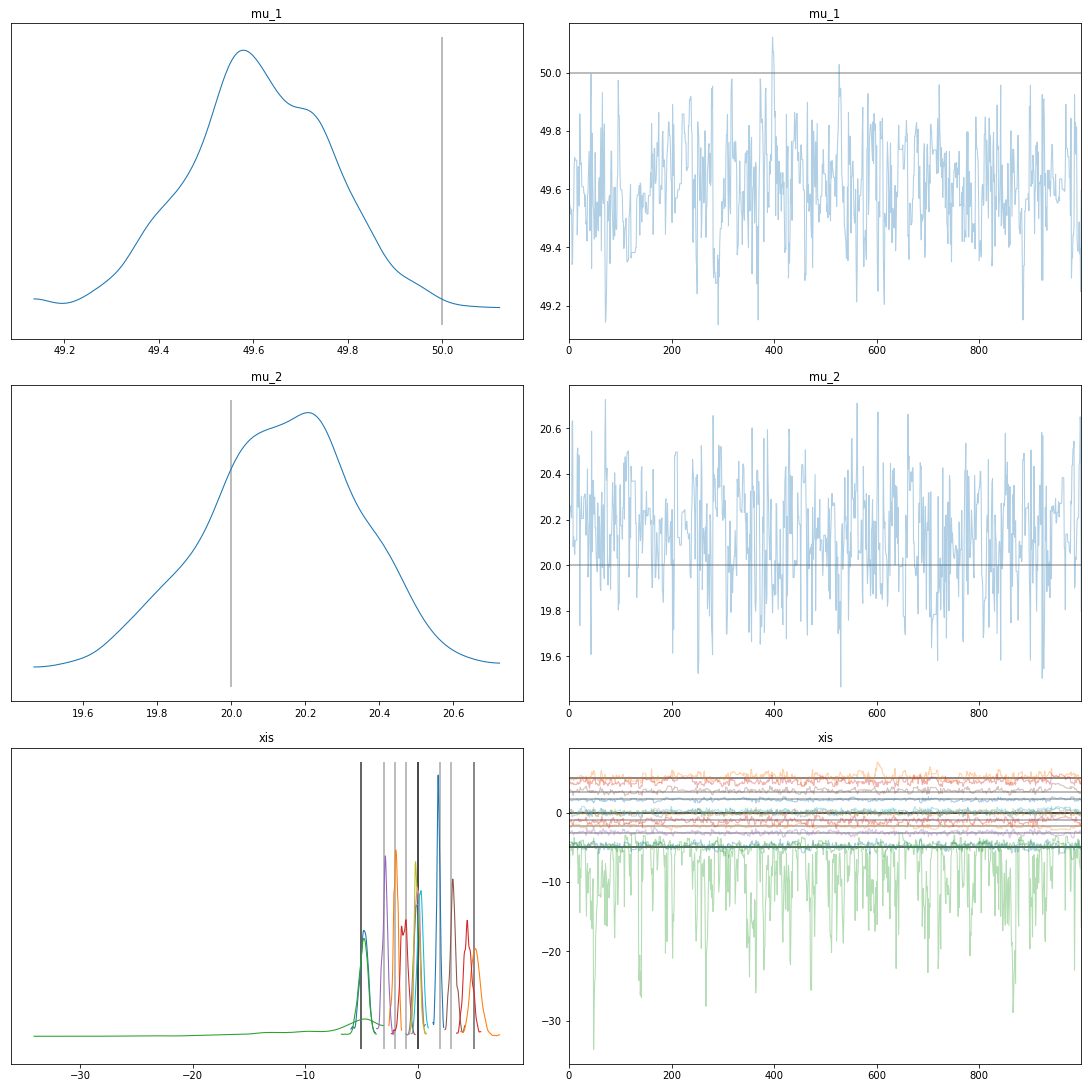

In [16]:
import arviz as az

import matplotlib.pyplot as plt


ax = az.plot_trace(
    posterior_trace.posterior,
    var_names=[
        "mu_1",
        "mu_2",
        "xis",
    ],
    lines=[
        ("mu_1", {}, [mu_1_true]),
        ("mu_2", {}, [mu_2_true]),
        ("xis", {}, [xis_true.data]),
    ],
    compact=True,
    figsize=(15, 15),
)

## Posterior Predictive Samples

In [17]:
with test_model:
    posterior_pred_trace = pm.sample_posterior_predictive(
        posterior_trace.posterior, var_names=["Y_t"]
    )

/home/bwillard/apps/anaconda3/envs/pymc3-hmm/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


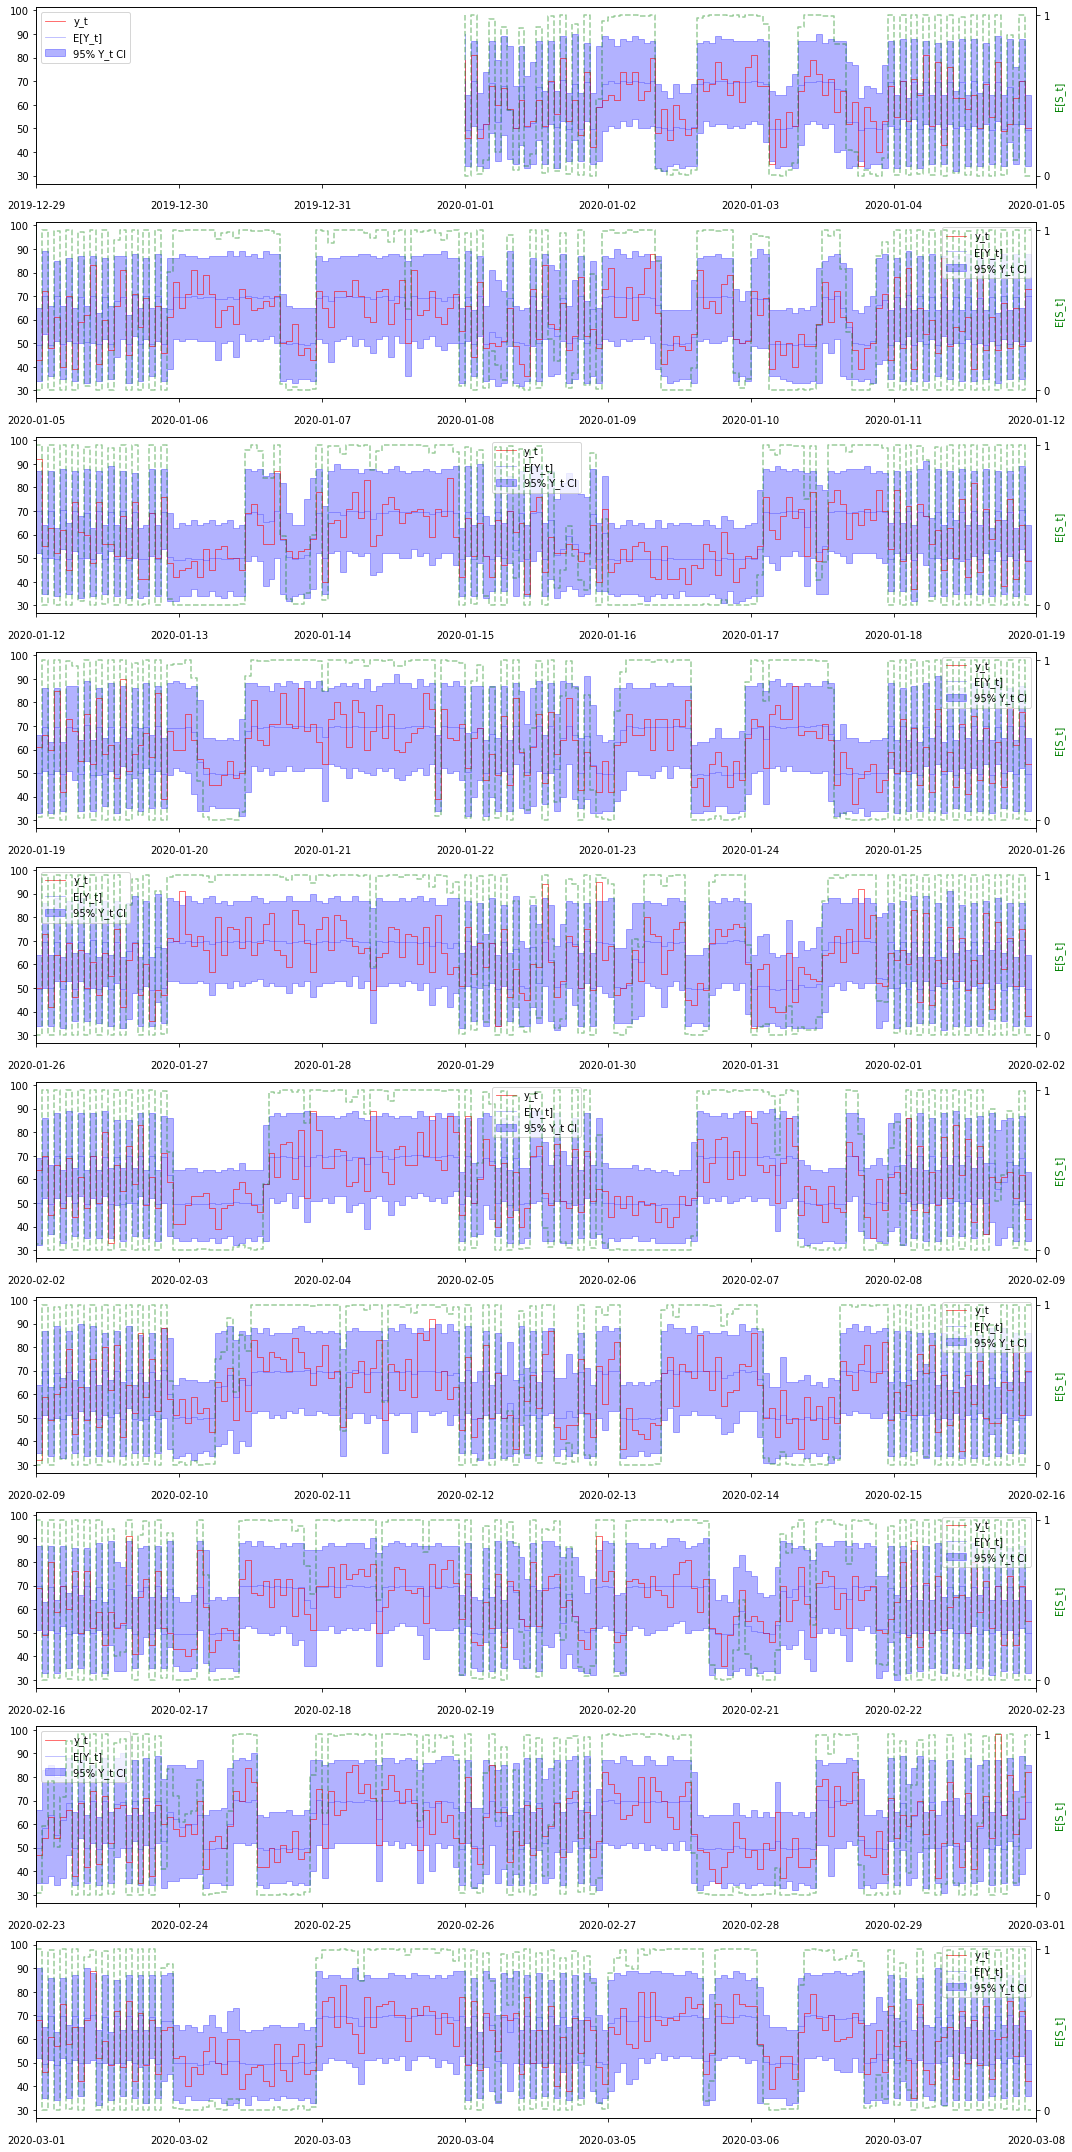

In [18]:
import pandas as pd


from matplotlib.ticker import MaxNLocator

from pymc3_hmm.utils import plot_split_timeseries


plot_data = pd.DataFrame({"y_t": y_t}, index=time_index)

with test_model:
    az_post_trace = az.from_pymc3(
        posterior_predictive=posterior_pred_trace,
        dims={"Y_t": ["dt"]},
        coords={"dt": plot_data.index},
    )

hdi_data = az.hdi(
    az_post_trace, hdi_prob=0.97, group="posterior_predictive", var_names=["Y_t"]
).to_dataframe()
hdi_data = hdi_data.unstack(level="hdi")

plot_data["E[Y_t]"] = az_post_trace.posterior_predictive["Y_t"].mean(axis=1).squeeze()
plot_data["E[S_t]"] = posterior_trace.posterior.S_t.mean(axis=1).squeeze()

plot_data = plot_data.merge(hdi_data, right_index=True, left_index=True)


def plot_fn(ax, data, **kwargs):
    ax.plot(
        data["y_t"],
        label="y_t",
        alpha=0.7,
        color="red",
        linewidth=0.8,
        drawstyle="steps",
    )

    ax.plot(
        data["E[Y_t]"],
        label="E[Y_t]",
        alpha=0.3,
        color="blue",
        linewidth=0.8,
        drawstyle="steps",
    )

    ax.fill_between(
        data.index,
        data[("Y_t", "lower")],
        data[("Y_t", "higher")],
        label=r"95% Y_t CI",
        color="b",
        step="pre",
        alpha=0.3,
    )


axes_split_data = plot_split_timeseries(
    plot_data,
    split_max=10,
    twin_column_name="E[S_t]",
    twin_plot_kwargs={
        "color": "green",
        "drawstyle": "steps",
        "linestyle": "--",
        "alpha": 0.4,
    },
    figsize=(15, 30),
    plot_fn=plot_fn,
)

for (_, twin_ax), _ in axes_split_data:
    _ = twin_ax.set_ylabel("E[S_t]", color=twin_ax.get_lines()[0].get_color())
    _ = twin_ax.yaxis.set_major_locator(MaxNLocator(integer=True))


plt.tight_layout()